## Solving PDEs using FEM

Classic example:

$$
\begin{align}
    - \Delta u &= f &&\text{in $\Omega$} \\
    u &= g &&\text{on $\partial \Omega$}
\end{align}
$$

with $f(x) = 1.0, g(x) = 2.0$

In [1]:
using Gridap

# Create cartesian mesh of 10 regularly-spaced cells
L = 1.0
domain = (0.0, L, 0.0, L, 0.0, L)
n = 10
partition = (n, n, n)
model = CartesianDiscreteModel(domain, partition)

# Dirichlet BCs everywhere
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"dirichlet", collect(1:8))

# Test space built from linear Lagrangian elements
order = 1
reffe = ReferenceFE(lagrangian, Float64, order)
V0    = TestFESpace(model, reffe; conformity=:H1, dirichlet_tags="dirichlet")

# Trial space
g(x) = 2.0
Ug = TrialFESpace(V0, g)

# Integration
degree = 2
Ω = Triangulation(model)
dΩ = Measure(Ω, degree)

# Weak form
f(x)    = 1.0
h(x)    = 3.0
a(u, v) = ∫( ∇(v)⋅∇(u) )*dΩ
b(v)    = ∫( v*f )*dΩ

# Build and solve FE problem
op = AffineFEOperator(a, b, Ug, V0)
ls = LUSolver()
solver = LinearFESolver(ls)
uh = Gridap.solve(solver, op)

# Write to VTK
writevtk(Ω, "results", cellfields=["uh" => uh])

(["results.vtu"],)

## Modelling toolkit and SciML ecosystem for ODEs

Consider the Lorenz attractor:

$$
\begin{align}
    \dot{x} &= \sigma y - \sigma x\\
    \dot{y} &= \rho x - xz - y\\
    \dot{z} &= xy - \beta z
\end{align}
$$

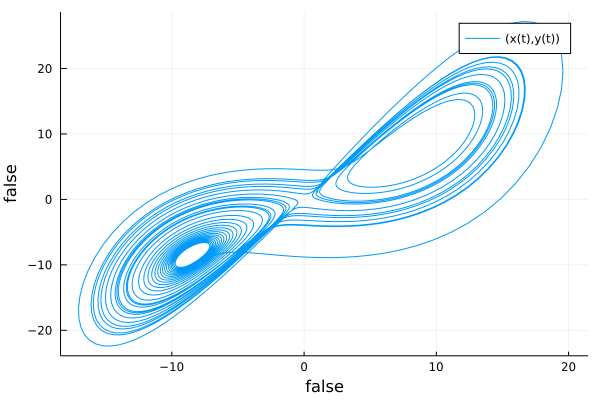

In [2]:
using ModelingToolkit
using OrdinaryDiffEq
using Plots

@parameters t σ ρ β
@variables x(t) y(t) z(t)
D = Differential(t)

eqs = [D(x) ~ σ*y - σ*x,
       D(y) ~ x*ρ - x*z - y,
       D(z) ~ x*y - β*z]

sys = ODESystem(eqs)
sys = ode_order_lowering(sys)

u0 = [x => 1.0,
      y => 1.0,
      z => 1.0]

p  = [σ => 10.0,
      ρ => 28.0,
      β => 8/3]

tspan = (0.0, 30.0)
prob = ODEProblem(sys, u0, tspan, p, jac=true)
sol = OrdinaryDiffEq.solve(prob, Tsit5())
plot(sol, vars=(x,y))

## Plane-wave discretisations using DFTK

Consider solving the Gross-Pitaevskii equation

$$
H ψ = \left(-\frac12 Δ + V + 2 C |ψ|^2\right) ψ = μ ψ \qquad \|ψ\|_{L^2} = 1
$$

with $C = 1$ in a periodic 1D "box" of length $10$ with confining potential $V(x) = (x - 5)^2$.

In [3]:
using DFTK
using Plots

lattice = 10 .* [[1 0 0.];
                 [0 0 0.];
                 [0 0 0.]]

V(x) = (x - 5)^2
terms = [Kinetic(),
         ExternalFromReal(r -> V(r[1])),
         PowerNonlinearity(2, 2),  # 2 * |ψ|^2
]
model = Model(lattice; n_electrons=1, terms=terms,
              spin_polarization=:spinless)  # use "spinless electrons"

Ecut = 500
basis = PlaneWaveBasis(model, Ecut, kgrid=(1, 1, 1))
    
# This is a constrained preconditioned LBFGS:
scfres = direct_minimization(basis, tol=1e-8);

Iter     Function value   Gradient norm 
     0     1.850844e+02     1.471991e+02
 * time: 0.2567911148071289
     1     1.759685e+02     1.215383e+02
 * time: 1.6529099941253662
     2     1.331446e+02     1.358635e+02
 * time: 1.785109043121338
     3     3.648767e+01     6.456738e+01
 * time: 1.7861831188201904
     4     1.201102e+01     1.100244e+01
 * time: 1.7870421409606934
     5     8.663574e+00     1.225857e+01
 * time: 1.7875380516052246
     6     5.815874e+00     2.738612e+01
 * time: 1.7881879806518555
     7     3.849071e+00     4.293621e+00
 * time: 1.7887721061706543
     8     3.215546e+00     4.495655e+00
 * time: 1.7892711162567139
     9     2.770716e+00     4.863256e+00
 * time: 1.7898590564727783
    10     2.485881e+00     3.461134e+00
 * time: 1.7903001308441162
    11     2.267542e+00     2.092504e+00
 * time: 1.7908051013946533
    12     2.045323e+00     1.867174e+00
 * time: 1.7914040088653564
    13     1.841321e+00     1.473484e+00
 * time: 1.79183197021

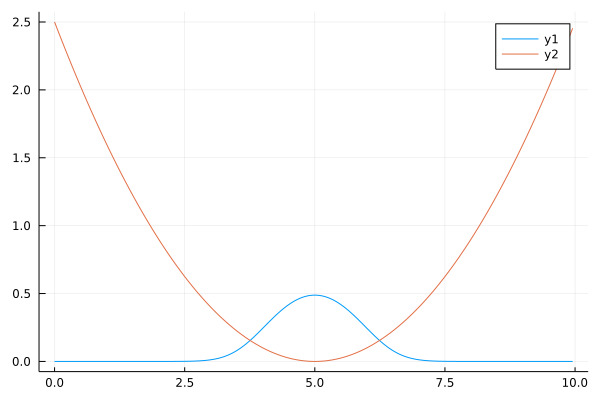

In [4]:
x = 10vec(first.(DFTK.r_vectors(basis)))
plot(x, scfres.ρ.real[:, 1, 1])
plot!(x, V.(x) / 10)